## 📈 Trend Analysis w DeepPulse

#### Research Question: Do shifts in media coverage and sentiment correlate with fluctuations in stock performance?

### STAGE 1: DATA EXTRACTION

#### In this section, a function called fetch_data is defined, which processes a CSV file by iterating through its entries, sending requests, storing the responses.

#### The function accepts three arguments:

##### 📂 CSV File – The input file containing the data to be processed.
##### 🌍 Language – Specifies the language for the request, accepting 'EN' (English) or 'DE' (German). Ensure it is enclosed in quotes.
##### ⏳ Timeframe – Defines the period for data retrieval, accepting "day", "week", "month", "twoMonths", "threeMonths". Ensure it is enclosed in quotes.

In [3]:
# 📚 Basic Libraries
import numpy as np 
import pandas as pd
import requests
from datetime import datetime
from datetime import timezone

# 📊 Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# ⚖️ Data Analysis

from scipy.stats import spearmanr
from scipy.stats import pearsonr

In [4]:
# GET DATA FUNCTION

def get_data(csv_file, language, timeframe):

    # Validate language input

    if language not in ['EN', 'DE']:
        raise ValueError("Invalid language option. Please choose 'EN' for English or 'DE' for German.")

    # Validate timeframe input
    
    valid_timeframes = ["day", "week", "month", "twoMonths", "threeMonths"]
    if timeframe not in valid_timeframes:
        raise ValueError(f"Invalid timeframe option. Please choose one of: {', '.join(valid_timeframes)}")
    
    # Load CSV file and clean column names

    input_df = pd.read_csv(csv_file, sep=';')
    input_df.columns = input_df.columns.str.strip()

    # Initialise an empty list for storing API results
    
    empty_list = []

    # API credentials

    api_key = "tQ5hcx7Djq5YUwl4AnFFF72ux3wwOKI9IXBZznu3"
    url = "https://api.dev.deeppulse.com/stock-analysis"

    # Iterate through each row in the CSV
    
    for index, row in input_df.iterrows():
        
        # Extract input parameters
        
        agent_query = row['Agent Query']
        company_name = row['Stock Company Name']
        ticker = row['Stock Ticker']
        exchange = row['Stock Exchange']

        # Prepare API request parameters

        params = {
            "queries": agent_query,
            "companyName": company_name,
            "ticker": ticker,
            "exchange": exchange,
            "timeframe": timeframe,
            "language": language

        }
        headers = {"x-api-key": api_key}

        #  Send request to API and process response

        response = requests.get(url, params=params, headers=headers)
        data = response.json()

        # Use the API ticker if available; otherwise, use the CSV ticker
        
        ticker_used = data.get('usedStockSymbol', ticker)

        # Retrieve stock price records

        stock_records = data.get('stockInfo', {}).get('price', {}).get('records', [])
        if not stock_records:
            print(f"No stock records available for {company_name} ({ticker_used}). Skipping.")
            continue

        # Convert stock data into a DataFrame

        stock_df = pd.DataFrame(stock_records)
        if 'timestamp' not in stock_df.columns or 'close' not in stock_df.columns:
            print(f"Missing required columns in stock records for {company_name} ({ticker_used}). Skipping.")
            continue

        # Convert timestamp to numeric format
        
        stock_df['timestamp'] = pd.to_numeric(stock_df['timestamp'], errors='coerce')
        stock_df = stock_df[['timestamp', 'close']]

        # Retrieve timeline data

        timeline = data.get('timeline', [])
        if not timeline:
            print(f"No timeline data available for {company_name} ({ticker_used}). Skipping.")
            continue
        
        # Process timeline entries
        
        for entry, next_entry in zip(timeline, timeline[1:] + [None]):
            # a. Extract time.
            start_time = entry['timeframe'][0]

            # Extract start time and convert to date format

            date_str = datetime.fromtimestamp(start_time / 1000, tz=timezone.utc).strftime('%Y-%m-%d')

            # Extract mentions and sentiment

            mentions = entry['amounts'].get('mentions', np.nan)
            sentiment = entry['amounts'].get('sentiment', np.nan)

            # Define timeframe for filtering stock records

            if next_entry:
                end_time = next_entry['timeframe'][0]
                mask = stock_df['timestamp'].between(start_time, end_time, inclusive='left')
            else:
                mask = stock_df['timestamp'] >= start_time

            # Find the highest stock close price within the timeframe
            highest_close = stock_df.loc[mask, 'close'].max()

            # Retrieve 52-week high value
            weekHigh52 = data.get("stockInfo", {}).get("fundamentals", {}).get("weekHigh52")

            # Append extracted data to results list

            empty_list.append({
                'ticker': ticker_used,
                'time': start_time,
                'date': date_str,
                'mentions': mentions,
                'sentiment': sentiment,
                'highest_close': highest_close,
                'weekHigh52': weekHigh52

            })

    # 10. Combine all results into a DataFrame.
    final_df = pd.DataFrame(empty_list)
    return final_df

In [5]:
# Fetch stock data for NASDAQ exchange.

NASDAQ_df = get_data('Tickers_NASDAQ.csv', 'EN', 'twoMonths')

In [6]:
NASDAQ_df

,ticker,time,date,mentions,sentiment,highest_close,weekHigh52
0,AAPL,1734912000000,2024-12-23,315,43.0,25511.0,25981.0
1,AAPL,1734998400000,2024-12-24,150,11.0,25793.0,25981.0
2,AAPL,1735084800000,2024-12-25,78,73.0,NaN,25981.0
3,AAPL,1735171200000,2024-12-26,162,58.0,25857.0,25981.0
4,AAPL,1735257600000,2024-12-27,147,46.0,25856.0,25981.0
...,...,...,...,...,...,...,...
2395,MU,1739664000000,2025-02-16,2,-70.0,NaN,15702.0
2396,MU,1739750400000,2025-02-17,1,30.0,NaN,15702.0
2397,MU,1739836800000,2025-02-18,0,30.0,10580.0,15702.0
2398,MU,1739923200000,2025-02-19,1,70.0,10710.0,15702.0


In [7]:
NASDAQ_df['highest_close'].count()

1520

In [8]:
# Save NASDAQ data to CSV for backup

NASDAQ_df.to_csv('NASDAQ_df.csv', index=False)

In [9]:
# Fetch stock data for LON exchange.

LON_df = get_data('Tickers_LON.csv', 'EN', 'twoMonths')

No stock records available for BP Plc (BP..LON). Skipping.
No stock records available for Rolls-Royce Holdings Plc (RR..LON). Skipping.
No stock records available for National Grid Plc (NG..LON). Skipping.
No stock records available for BAE Systems Plc (BA..LON). Skipping.
No stock records available for Standard Chartered Plc (STAN.LON). Skipping.
No stock records available for Tesco Plc (TSCO.LON). Skipping.
No stock records available for Imperial Brands Plc (IMB.LON). Skipping.
No stock records available for Ashtead Group Plc (AHT.LON). Skipping.
No stock records available for Prudential Plc (PRU.LON). Skipping.
No stock records available for Antofagasta Plc (ANTO.LON). Skipping.
No stock records available for Vodafone Group Plc (VOD.LON). Skipping.
No stock records available for InterContinental Hotels Group Plc (IHG.LON). Skipping.
No stock records available for International Consolidated Airlines Group SA (IAG.LON). Skipping.
No stock records available for SSE Plc (SSE.LON). Skipp

In [10]:
LON_df

,ticker,time,date,mentions,sentiment,highest_close,weekHigh52
0,AZN.LON,1734912000000,2024-12-23,15,13.0,1042200.0,None
1,AZN.LON,1734998400000,2024-12-24,9,-40.0,1043600.0,None
2,AZN.LON,1735084800000,2024-12-25,1,-40.0,NaN,None
3,AZN.LON,1735171200000,2024-12-26,1,-40.0,NaN,None
4,AZN.LON,1735257600000,2024-12-27,3,50.0,1046000.0,None
...,...,...,...,...,...,...,...
1195,AAL.LON,1739664000000,2025-02-16,0,66.0,NaN,None
1196,AAL.LON,1739750400000,2025-02-17,10,74.0,247350.0,None
1197,AAL.LON,1739836800000,2025-02-18,6,30.0,245300.0,None
1198,AAL.LON,1739923200000,2025-02-19,2,-55.0,237000.0,None


In [11]:
# Save NASDAQ data to CSV for backup

LON_df.to_csv('LON_df.csv', index=False)

### STAGE 2: DATA CLEANING

#### In this section, the dataset is reviewed to ensure all stock information has been retrieved correctly and is ready for analysis. This involves checking for missing values, incomplete records, or inconsistencies.

#### Found the following data issues, then made changes to the csv files and restarted the notebook:

##### Companies with generic names

##### Companies with multiple stock tickers

In [14]:
# Check number of rows & columns in datasets

NASDAQ_df.shape

(2400, 7)

In [15]:
LON_df.shape

(1200, 7)

In [16]:
# Confirming that 'weekHigh52' contains no valid data in LON_df

LON_df['weekHigh52'].isna().sum()

1200

In [17]:
# Dropping 'weekHigh52' column

LON_df = LON_df.drop(columns=['weekHigh52'])

In [18]:
# Verify that all DeepPulse metrics (i.e. Mentions & Sentiment) were successfully retrieved

In [19]:
# Checking 'mentions' column for missing values

NASDAQ_df['mentions'].isnull().sum()

0

In [20]:
# Counting rows where mentions == 0

(NASDAQ_df['mentions'] == 0).sum()

843

In [21]:
# Checking 'mentions' column for missing values

LON_df['mentions'].isnull().sum()

0

In [22]:
# Counting rows where mentions == 0

(LON_df['mentions'] == 0).sum()

418

In [23]:
# Checking 'sentiment' column for missing values

NASDAQ_df['sentiment'].isnull().sum()

154

In [24]:
# Counting rows where sentiment == 0

(NASDAQ_df['sentiment'] == 0).sum()

22

In [25]:
# Checking 'sentiment' column for missing values

LON_df['sentiment'].isnull().sum()

20

In [26]:
# Counting rows where sentiment == 0

(LON_df['sentiment'] == 0).sum()

26

In [27]:
# Identify which tickers have the most missing sentiment values

NASDAQ_missing_sentiment = NASDAQ_df[NASDAQ_df['sentiment'].isna()].groupby('ticker').size()

NASDAQ_missing_sentiment = NASDAQ_missing_sentiment.sort_values(ascending=False)

NASDAQ_missing_sentiment

ticker
BKNG    60
ADP     28
HON     21
ISRG    11
LIN     11
AMAT     9
ADI      4
GILD     4
PDD      2
AVGO     1
AZN      1
CSCO     1
PANW     1
dtype: int64

In [28]:
# Drop tickers where there is not enough sentiment 
# Sentiment = NaN indicates no mentions data / but i don't want to just drop mentions == 0 rows bc i might need it for my time series data

# Drop tickers with insufficient sentiment data  
# Sentiment == NaN indicates no mentions were recorded  
# Dropping rows where mentions == 0 is inadvisable, as these may be useful for time series analysis  

NASDAQ_df = NASDAQ_df.query("ticker not in ['BKNG', 'HON', 'ISRG', 'LIN']")

In [29]:
# Identify which tickers have the most missing sentiment values

LON_missing_sentiment = LON_df[LON_df['sentiment'].isna()].groupby('ticker').size()

LON_missing_sentiment = LON_missing_sentiment.sort_values(ascending=False)

LON_missing_sentiment

ticker
HLN.LON     7
RKT.LON     7
NWG.LON     2
AAL.LON     1
AZN.LON     1
EXPN.LON    1
GSK.LON     1
dtype: int64

In [30]:
# Checking 'highest_close' column for missing values

NASDAQ_df['highest_close'].isnull().sum()

792

In [31]:
# Checking 'highest_close' column for missing values

LON_df['highest_close'].isnull().sum()

400

In [32]:
# Having 'highest_close' data for only a third of stocks is unusual.
# E.g. NASDAQ is open 5 days a week, so expect more data.

In [33]:
# Investigate missing 'highest_close' values by day of the week

NASDAQ_df['date'] = pd.to_datetime(NASDAQ_df['date'])

NASDAQ_df['day_of_week'] = NASDAQ_df['date'].dt.day_name()

NASDAQ_missing_day = NASDAQ_df[NASDAQ_df['highest_close'].isna()].groupby('day_of_week').size()

NASDAQ_missing_day

/var/folders/wh/mdt4h3r54f11yvfsw8xvpf040000gn/T/ipykernel_65124/981167762.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NASDAQ_df['date'] = pd.to_datetime(NASDAQ_df['date'])
/var/folders/wh/mdt4h3r54f11yvfsw8xvpf040000gn/T/ipykernel_65124/981167762.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NASDAQ_df['day_of_week'] = NASDAQ_df['date'].dt.day_name()


day_of_week
Monday        72
Saturday     288
Sunday       288
Thursday      72
Wednesday     72
dtype: int64

In [34]:
# Investigate missing 'highest_close' values by day of the week

LON_df['date'] = pd.to_datetime(LON_df['date'])

LON_df['day_of_week'] = LON_df['date'].dt.day_name()

LON_missing_day = LON_df[LON_df['highest_close'].isna()].groupby('day_of_week').size()

LON_missing_day

day_of_week
Saturday     160
Sunday       160
Thursday      40
Wednesday     40
dtype: int64

### STAGE 3: EXPLORATORY DATA ANALYSIS

#### In this section, the cleaned dataset is explored to identify trends, patterns, and relationships within the stock data.

In [36]:
# Generate summary statistics

NASDAQ_df[['mentions', 'sentiment', 'highest_close', 'weekHigh52']].describe().round(2)

,mentions,sentiment,highest_close,weekHigh52
count,2160.00,2109.00,1368.00,1500.00
mean,31.79,28.21,27721.82,31073.08
std,76.21,42.77,23900.73,28709.93
min,0.00,-90.00,3315.00,4493.00
25%,0.00,4.00,10904.00,11347.00
50%,2.00,33.00,19355.50,22825.00
75%,14.00,63.00,37725.25,31372.00
max,683.00,100.00,107974.00,110309.00


In [37]:
# Find the mean values for mentions, sentiment, and highest_close per ticker  
# Rounded to two decimal places, mentions in descending order

NASDAQ_df.groupby('ticker')[['mentions', 'sentiment', 'highest_close']].mean().round(2).sort_values(by='mentions', ascending=False)

,mentions,sentiment,highest_close
ticker,,,
NFLX,251.10,35.55,94830.03
AMZN,229.13,12.50,22976.21
AAPL,216.47,24.55,23935.34
META,104.77,-7.85,65475.66
TSLA,93.80,-21.48,40167.05
NVDA,62.43,37.28,13586.76
MSFT,60.93,10.42,42517.79
SBUX,16.82,10.18,10026.42
COST,15.93,9.68,97632.61


In [38]:
NASDAQ_df['ticker'].nunique()

36

In [39]:
# Drop tickers where the average mentions count is less than 3

NASDAQ_df = NASDAQ_df.groupby('ticker').filter(lambda x: x['mentions'].mean() >= 3)

In [40]:
NASDAQ_df['ticker'].nunique()

20

In [42]:
# Generate summary statistics

LON_df[['mentions', 'sentiment', 'highest_close']].describe().round(2)

,mentions,sentiment,highest_close
count,1200.00,1180.00,800.00
mean,5.61,16.02,328204.35
std,11.84,45.25,313809.94
min,0.00,-90.00,5288.00
25%,0.00,-20.00,68632.50
50%,1.00,20.00,267550.00
75%,5.00,50.00,418625.00
max,120.00,90.00,1209500.00


In [44]:
# Find the mean values for mentions, sentiment, and highest_close per ticker  
# Rounded to two decimal places, mentions in descending order

LON_df.groupby('ticker')[['mentions', 'sentiment', 'highest_close']].mean().round(2).sort_values(by='mentions', ascending=False)

,mentions,sentiment,highest_close
ticker,,,
SHEL.LON,27.55,-2.93,262205.00
BARC.LON,20.95,12.72,28542.38
HSBA.LON,14.60,18.18,82393.25
LLOY.LON,12.73,-10.23,5915.10
NWG.LON,5.93,14.03,41789.75
AZN.LON,5.45,-3.14,1108665.00
DGE.LON,5.10,2.83,237725.00
RIO.LON,4.15,14.73,489130.00
ULVR.LON,3.22,25.22,456612.50


In [46]:
LON_df['ticker'].nunique()

20

In [48]:
# Drop tickers where the average mentions count is less than 3

LON_df = LON_df.groupby('ticker').filter(lambda x: x['mentions'].mean() >= 3)

In [50]:
LON_df['ticker'].nunique()

9

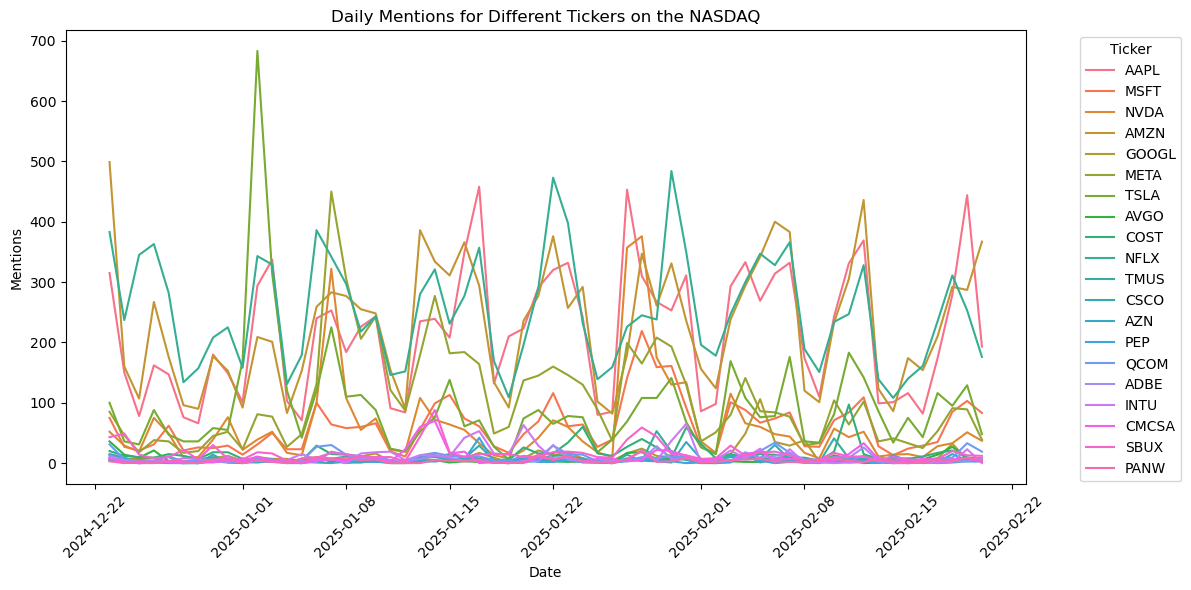

In [56]:
# Visualise mentions over time using a line graph

# Set figure size
plt.figure(figsize=(12, 6))

# Create a line plot for mentions over time, grouped by ticker
sns.lineplot(data=NASDAQ_df, x='date', y='mentions', hue='ticker')

# Customize the plot
plt.title("Daily Mentions for Different Tickers on the NASDAQ")
plt.xlabel("Date")
plt.ylabel("Mentions")
plt.xticks(rotation=45)

# Show the legend
plt.legend(title="Ticker", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [58]:
# Calculate the average mentions for Weekdays vs Weekends

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
weekends = ["Saturday", "Sunday"]

NASDAQ_df['day_type'] = NASDAQ_df['day_of_week'].apply(lambda x: 'Weekday' if x in weekdays else 'Weekend')

NASDAQ_df.groupby('day_type')['mentions'].mean().round(2)

day_type
Weekday    67.02
Weekend    27.67
Name: mentions, dtype: float64

In [60]:
76.18/31.70

2.4031545741324924

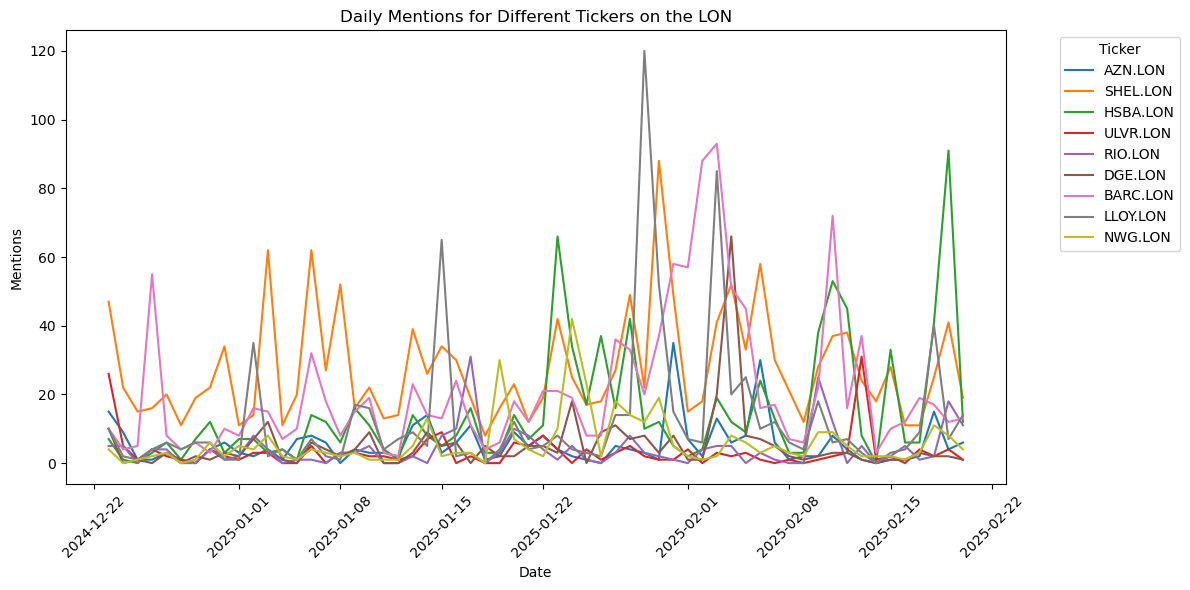

In [62]:
# Visualise mentions over time using a line graph

# Set figure size
plt.figure(figsize=(12, 6))

# Create a line plot for mentions over time, grouped by ticker
sns.lineplot(data=LON_df, x='date', y='mentions', hue='ticker')

# Customize the plot
plt.title("Daily Mentions for Different Tickers on the LON")
plt.xlabel("Date")
plt.ylabel("Mentions")
plt.xticks(rotation=45)

# Show the legend
plt.legend(title="Ticker", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [64]:
# Calculate the average mentions for Weekdays vs Weekends

LON_df['day_type'] = LON_df['day_of_week'].apply(lambda x: 'Weekday' if x in weekdays else 'Weekend')

LON_df.groupby('day_type')['mentions'].mean().round(2)

day_type
Weekday    12.97
Weekend     5.88
Name: mentions, dtype: float64

In [66]:
15.18/6.87

2.2096069868995634

In [68]:
NASDAQ_df.groupby('ticker')[['mentions', 'sentiment', 'highest_close']].mean().round(2).sort_values(by='mentions', ascending=False)

,mentions,sentiment,highest_close
ticker,,,
NFLX,251.10,35.55,94830.03
AMZN,229.13,12.50,22976.21
AAPL,216.47,24.55,23935.34
META,104.77,-7.85,65475.66
TSLA,93.80,-21.48,40167.05
NVDA,62.43,37.28,13586.76
MSFT,60.93,10.42,42517.79
SBUX,16.82,10.18,10026.42
COST,15.93,9.68,97632.61


In [70]:
LON_df.groupby('ticker')[['mentions', 'sentiment', 'highest_close']].mean().round(2).sort_values(by='mentions', ascending=False)

,mentions,sentiment,highest_close
ticker,,,
SHEL.LON,27.55,-2.93,262205.00
BARC.LON,20.95,12.72,28542.38
HSBA.LON,14.60,18.18,82393.25
LLOY.LON,12.73,-10.23,5915.10
NWG.LON,5.93,14.03,41789.75
AZN.LON,5.45,-3.14,1108665.00
DGE.LON,5.10,2.83,237725.00
RIO.LON,4.15,14.73,489130.00
ULVR.LON,3.22,25.22,456612.50


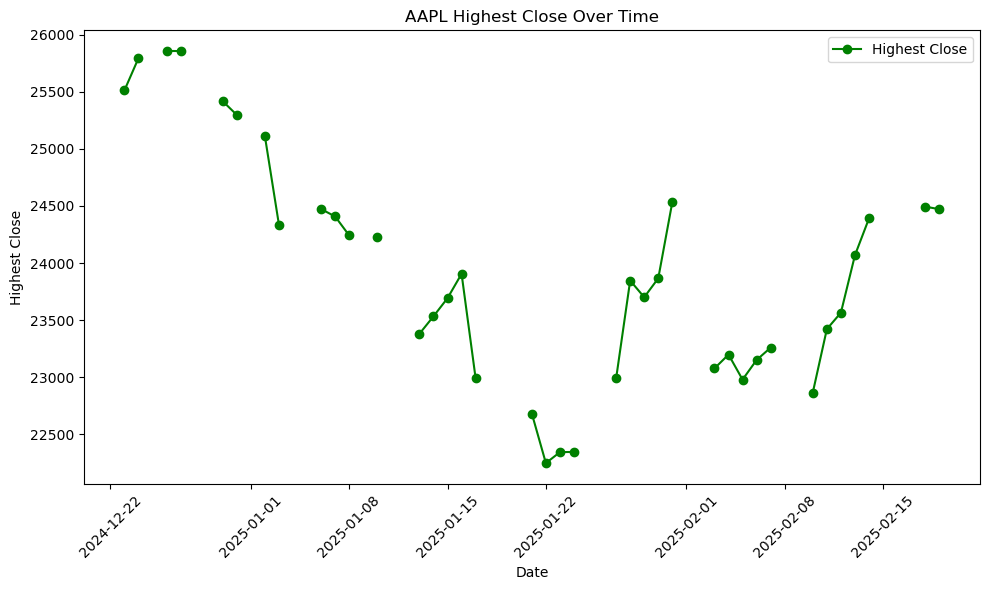

In [74]:
# Line graph showing Apple's (AAPL) highest close over time  
# The dates with data avalible will be the same for all stocks in this dataset  

aapl_df = NASDAQ_df[NASDAQ_df['ticker'] == 'AAPL']

plt.figure(figsize=(10, 6))
plt.plot(aapl_df['date'], aapl_df['highest_close'], marker='o', color='green', label='Highest Close')
plt.title('AAPL Highest Close Over Time')
plt.xlabel('Date')
plt.ylabel('Highest Close')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

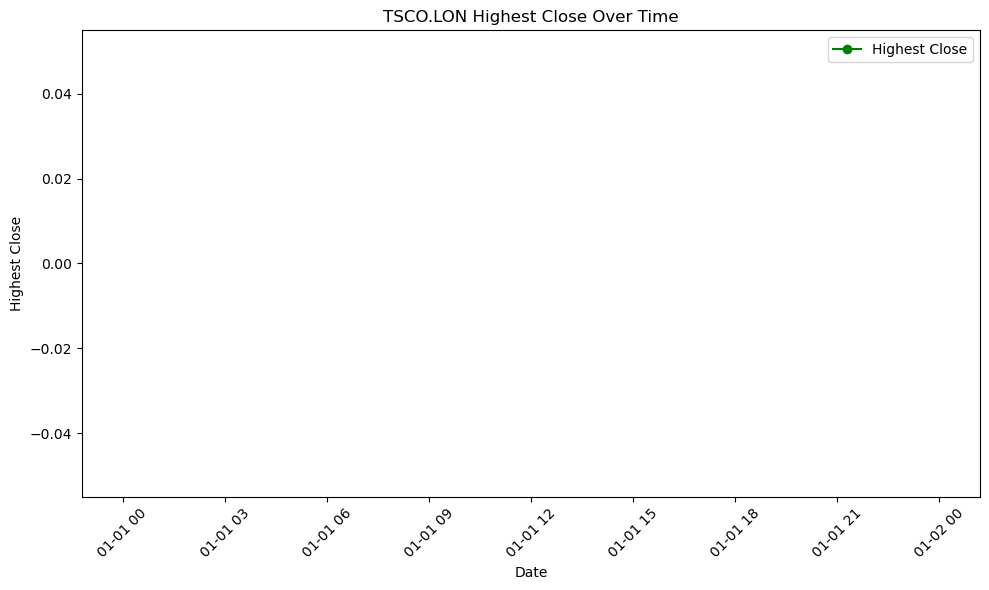

In [76]:
# Line graph showing Tesco's (TSCO.LON) highest close over time  
# The dates with data avalible will be the same for all stocks in this dataset  

tsco_df = LON_df[LON_df['ticker'] == 'TSCO.LON']

plt.figure(figsize=(10, 6))
plt.plot(tsco_df['date'], tsco_df['highest_close'], marker='o', color='green', label='Highest Close')
plt.title('TSCO.LON Highest Close Over Time')
plt.xlabel('Date')
plt.ylabel('Highest Close')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### STAGE 4: FEATURE ENGINEERING

#### In this section, new features are created to enhance the dataset for analysis. This includes calculating price changes over different timeframes and normalisation.

In [78]:
# Create a new column called 'highest_close_DoD_change'

NASDAQ_df['prev_valid_highest_close'] = NASDAQ_df.groupby('ticker')['highest_close'].ffill().shift(1)

NASDAQ_df['highest_close_DoD_change'] = NASDAQ_df['highest_close'] - NASDAQ_df['prev_valid_highest_close']

NASDAQ_df.drop(columns=['prev_valid_highest_close'], inplace=True)

NASDAQ_df

,ticker,time,date,mentions,sentiment,highest_close,weekHigh52,day_of_week,day_type,highest_close_DoD_change
0,AAPL,1734912000000,2024-12-23,315,43.0,25511.0,25981.0,Monday,Weekday,NaN
1,AAPL,1734998400000,2024-12-24,150,11.0,25793.0,25981.0,Tuesday,Weekday,282.0
2,AAPL,1735084800000,2024-12-25,78,73.0,NaN,25981.0,Wednesday,Weekday,NaN
3,AAPL,1735171200000,2024-12-26,162,58.0,25857.0,25981.0,Thursday,Weekday,64.0
4,AAPL,1735257600000,2024-12-27,147,46.0,25856.0,25981.0,Friday,Weekday,-1.0
...,...,...,...,...,...,...,...,...,...,...
2215,PANW,1739664000000,2025-02-16,1,50.0,NaN,NaN,Sunday,Weekend,NaN
2216,PANW,1739750400000,2025-02-17,6,23.0,NaN,NaN,Monday,Weekday,NaN
2217,PANW,1739836800000,2025-02-18,3,65.0,20445.0,NaN,Tuesday,Weekday,819.0
2218,PANW,1739923200000,2025-02-19,9,-26.0,20728.0,NaN,Wednesday,Weekday,283.0


In [80]:
# Create a new column called 'highest_close_DoD_change'

LON_df['prev_valid_highest_close'] = LON_df.groupby('ticker')['highest_close'].ffill().shift(1)

LON_df['highest_close_DoD_change'] = LON_df['highest_close'] - LON_df['prev_valid_highest_close']

LON_df.drop(columns=['prev_valid_highest_close'], inplace=True)

LON_df

,ticker,time,date,mentions,sentiment,highest_close,day_of_week,day_type,highest_close_DoD_change
0,AZN.LON,1734912000000,2024-12-23,15,13.0,1042200.0,Monday,Weekday,NaN
1,AZN.LON,1734998400000,2024-12-24,9,-40.0,1043600.0,Tuesday,Weekday,1400.0
2,AZN.LON,1735084800000,2024-12-25,1,-40.0,NaN,Wednesday,Weekday,NaN
3,AZN.LON,1735171200000,2024-12-26,1,-40.0,NaN,Thursday,Weekday,NaN
4,AZN.LON,1735257600000,2024-12-27,3,50.0,1046000.0,Friday,Weekday,2400.0
...,...,...,...,...,...,...,...,...,...
1135,NWG.LON,1739664000000,2025-02-16,1,-50.0,NaN,Sunday,Weekend,NaN
1136,NWG.LON,1739750400000,2025-02-17,3,60.0,43900.0,Monday,Weekday,1090.0
1137,NWG.LON,1739836800000,2025-02-18,11,63.0,44520.0,Tuesday,Weekday,620.0
1138,NWG.LON,1739923200000,2025-02-19,8,50.0,43970.0,Wednesday,Weekday,-550.0


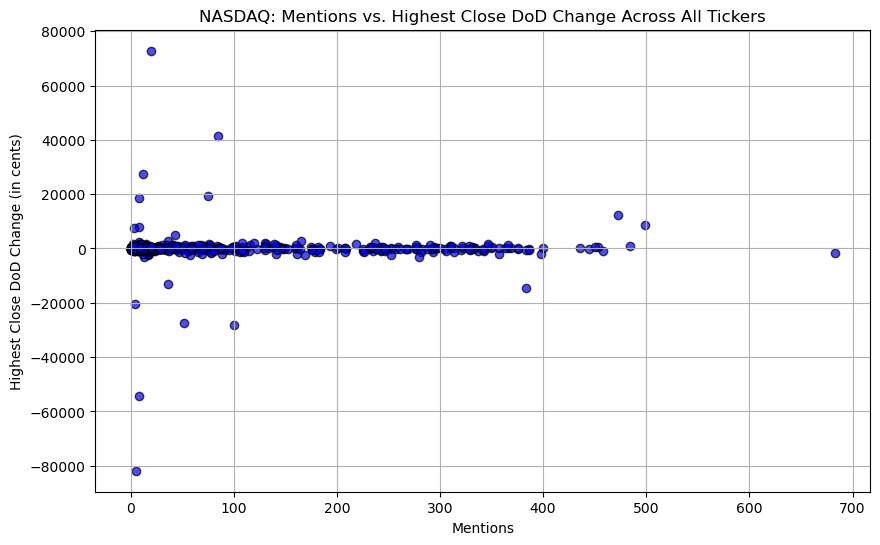

In [82]:
# Create the scatter plot for all tickers

plt.figure(figsize=(10, 6))
plt.scatter(NASDAQ_df['mentions'], NASDAQ_df['highest_close_DoD_change'], 
            color='blue', alpha=0.7, edgecolor='k')

plt.xlabel('Mentions')
plt.ylabel('Highest Close DoD Change (in cents)')
plt.title('NASDAQ: Mentions vs. Highest Close DoD Change Across All Tickers')
plt.grid(True)
plt.show()

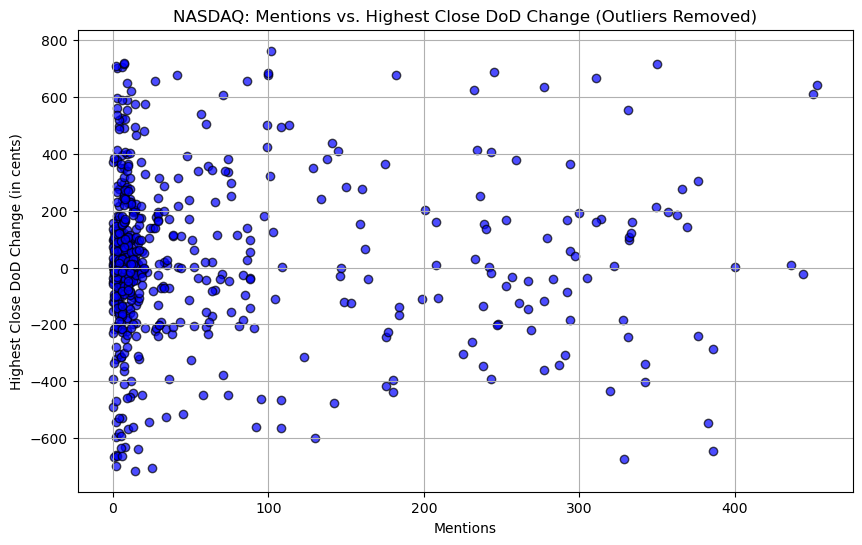

In [84]:
# Remove outliers from the dataset

Q1 = NASDAQ_df['highest_close_DoD_change'].quantile(0.25)
Q3 = NASDAQ_df['highest_close_DoD_change'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_df = NASDAQ_df[(NASDAQ_df['highest_close_DoD_change'] >= lower_bound) & 
                         (NASDAQ_df['highest_close_DoD_change'] <= upper_bound)]

filtered_df = filtered_df.sort_values(by=['ticker', 'mentions'], ascending=True)

plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['mentions'], filtered_df['highest_close_DoD_change'], 
            color='blue', alpha=0.7, edgecolor='k')

plt.xlabel('Mentions')
plt.ylabel('Highest Close DoD Change (in cents)')
plt.title('NASDAQ: Mentions vs. Highest Close DoD Change (Outliers Removed)')
plt.grid(True)
plt.show()

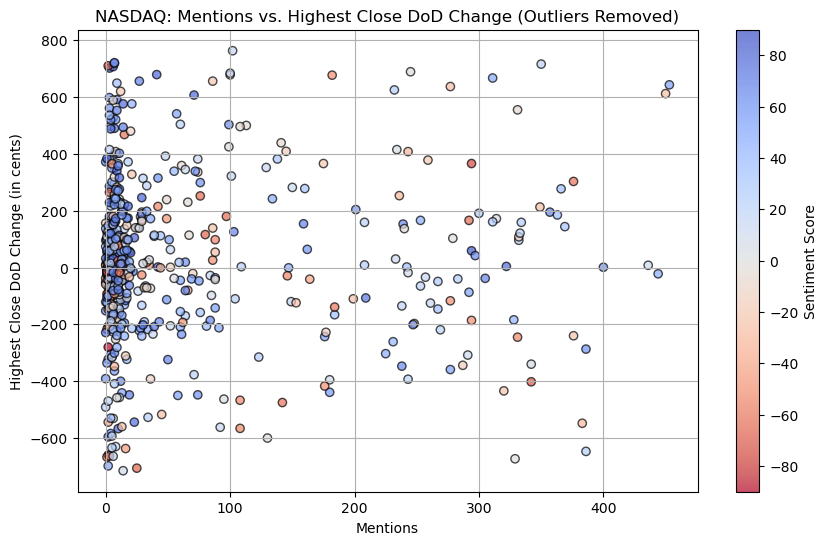

In [86]:
# Create scatter plot with sentiment-based colouring

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    filtered_df['mentions'], 
    filtered_df['highest_close_DoD_change'], 
    c=filtered_df['sentiment'],
    cmap='coolwarm_r',
    alpha=0.7, 
    edgecolor='k'
)

plt.xlabel('Mentions')
plt.ylabel('Highest Close DoD Change (in cents)')
plt.title('NASDAQ: Mentions vs. Highest Close DoD Change (Outliers Removed)')

cbar = plt.colorbar(scatter)
cbar.set_label('Sentiment Score')

plt.grid(True)
plt.show()

In [88]:
# Compute Pearson correlation

r, p_value = pearsonr(filtered_df['mentions'], filtered_df['highest_close_DoD_change'])

print(f"Pearson correlation coefficient: {r:.4f}")
print(f"P-value: {p_value:.4f}")

Pearson correlation coefficient: 0.0189
P-value: 0.6366


In [90]:
# A Pearson correlation coefficient of 0.0189 suggests almost no linear correlation between mentions and highest_close_DoD_change

In [92]:
# Compute Spearman correlation

spearman_r, spearman_p = spearmanr(filtered_df['mentions'], filtered_df['highest_close_DoD_change'])

print(f"Spearman correlation coefficient: {spearman_r:.4f}")
print(f"P-value: {spearman_p:.4f}")

Spearman correlation coefficient: 0.0292
P-value: 0.4661


In [ ]:
# A Spearman correlation coefficient of 0.0292 suggests a very weak positive correlation between the two variables.